In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

### Data Load

In [3]:
def cal_log_price(data):
    data = data.pct_change().apply(lambda x: np.log(1+x)).iloc[1:,:]
    return data

In [4]:
import yfinance as yf

# S&P 500 섹터 지수 심볼 리스트
symbols = [   
    "^GSPC", # S&P 500
    
]


# 데이터 다운로드
data = yf.download(symbols, start="1999-01-01", end="2022-07-17")#interval='1wk'

[*********************100%%**********************]  1 of 1 completed


In [264]:
# 다양한 컬럼 중에서 수정종가만 인덱싱
daily_data = pd.DataFrame(data["Adj Close"]) 
# 데이터 pandas 데이터 형식으로 변환
daily_data.index = pd.DatetimeIndex(daily_data.index).strftime('%Y-%m-%d %H:%M:%S')
#주간 데이터로 변환(들고 올 때 부터 주간으로 들고 올 수 있는데 이러면 날짜 인덱싱이 어려움)
weekly_data = daily_data.rolling(window=5).mean().iloc[4::5]

weekly_data.index = pd.to_datetime(weekly_data.index)

In [265]:
weekly_data.dropna(axis=1, inplace=True)
#log price 변환
weekly_data_log = cal_log_price(weekly_data)

In [266]:
daily_data_log = cal_log_price(daily_data)

In [267]:
weekly_data

,Adj Close
Date,
1999-01-08,1258.007983
1999-01-15,1238.647998
1999-01-25,1240.589990
1999-02-01,1262.698022
1999-02-08,1253.143994
...,...
2022-06-13,3988.952051
2022-06-21,3726.374023
2022-06-28,3837.804004


### 데이터 Maker

In [268]:
def datamaker(data,IS,OS,col_num=0,window=1000):
    return data.iloc[-window:,col_num]


In [269]:
weekly_data

,Adj Close
Date,
1999-01-08,1258.007983
1999-01-15,1238.647998
1999-01-25,1240.589990
1999-02-01,1262.698022
1999-02-08,1253.143994
...,...
2022-06-13,3988.952051
2022-06-21,3726.374023
2022-06-28,3837.804004


### 데이터 분석

(array([173., 522.,  86., 131.,  79.,  80.,  29.,  24.,  28.,  32.]),
 array([ 690.33200684, 1099.8602124 , 1509.38841797, 1918.91662354,
        2328.4448291 , 2737.97303467, 3147.50124023, 3557.0294458 ,
        3966.55765137, 4376.08585693, 4785.6140625 ]),
 <BarContainer object of 10 artists>)

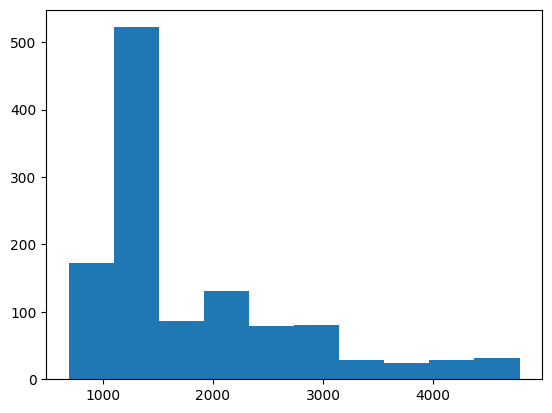

In [270]:
plt.hist(weekly_data)

(array([173., 522.,  86., 131.,  79.,  80.,  29.,  24.,  28.,  32.]),
 array([ 690.33200684, 1099.8602124 , 1509.38841797, 1918.91662354,
        2328.4448291 , 2737.97303467, 3147.50124023, 3557.0294458 ,
        3966.55765137, 4376.08585693, 4785.6140625 ]),
 <BarContainer object of 10 artists>)

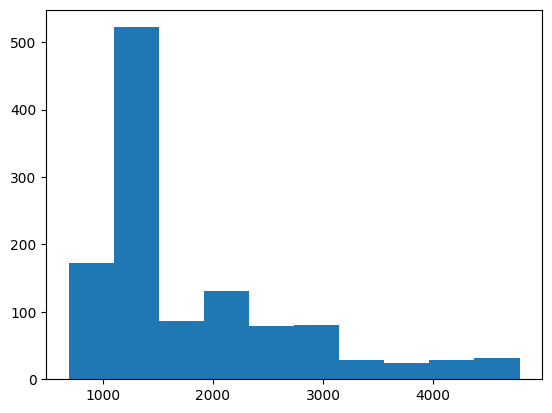

In [271]:
plt.hist(weekly_data)

## Clustering
### 다양한 클러스터 모델을 사용해서 IS(In Sample) OS(Out Sample) 기간의 군집이 차이나는지 확인 
IS OS를 분리해서 보는 이유는 전체적으로 봤을때 IS 길이가 더 길기에 구별됨에도 그 영향이 작게 보일 수 있기 때문이다

### GMM

In [272]:
daily_data.dropna(axis=1, inplace=True)
daily_data_log.dropna(axis=1, inplace=True)

In [273]:
daily_data = daily_data.mean(axis=1)
daily_data_log = daily_data_log.mean(axis=1)

In [274]:
position = daily_data.index.get_loc('2008-09-15 00:00:00')
position

2439

In [275]:
def cal_period(position):
    IS = np.array(daily_data[:position]).reshape(-1,1)
    OS = np.array(daily_data[position:]).reshape(-1,1)
    IS_OS = np.array(daily_data[:])
    IS_log = np.array(daily_data_log[:position]).reshape(-1,1)
    OS_log  = np.array(daily_data_log[position:]).reshape(-1,1)
    IS_OS_log = np.array(daily_data_log[:]).reshape(-1,1)
    return IS, OS,IS_OS ,IS_log, OS_log, IS_OS_log


In [276]:
IS, OS,IS_OS ,IS_log, OS_log, IS_OS_log = cal_period(position = daily_data.index.get_loc('2020-03-02 00:00:00'))

In [277]:
def GMM_AIC_BIC(data,title):
    aic_values = []
    bic_values = []
    X = data
    # 클러스터 개수를 변경하면서 AIC와 BIC 값을 계산합니다.
    for n_components in range(1, 11):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        aic_values.append(gmm.aic(X))
        bic_values.append(gmm.bic(X))
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), aic_values, marker='o', label='AIC')
    plt.plot(range(1, 11), bic_values, marker='s', label='BIC')
    plt.xlabel('Number of Components')
    plt.ylabel('Value')
    plt.title(title)
    plt.xticks(range(1, 11))
    plt.legend()
    plt.grid(True)
    plt.show()
    print('min AIC index:',np.argmin(aic_values))
    print('min AIC value:',np.min(aic_values))
    print('min BIC index:',np.argmin(bic_values))
    print('min BIC values:',np.min(bic_values))
def func_IS_OS(IS,OS):
    GMM_AIC_BIC(IS,'IS_2020')
    GMM_AIC_BIC(OS,'OS_Log_2020')

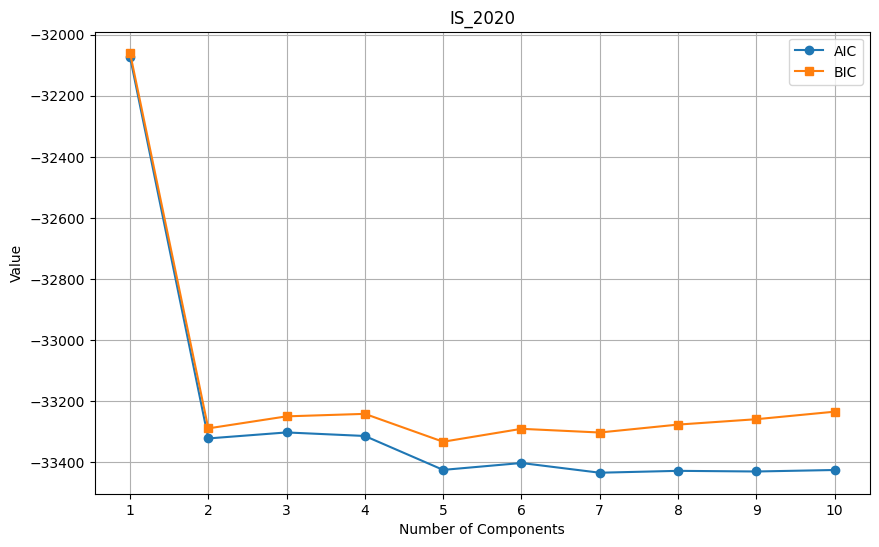

min AIC index: 6
min AIC value: -33434.0459515775
min BIC index: 4
min BIC values: -33332.67983305432


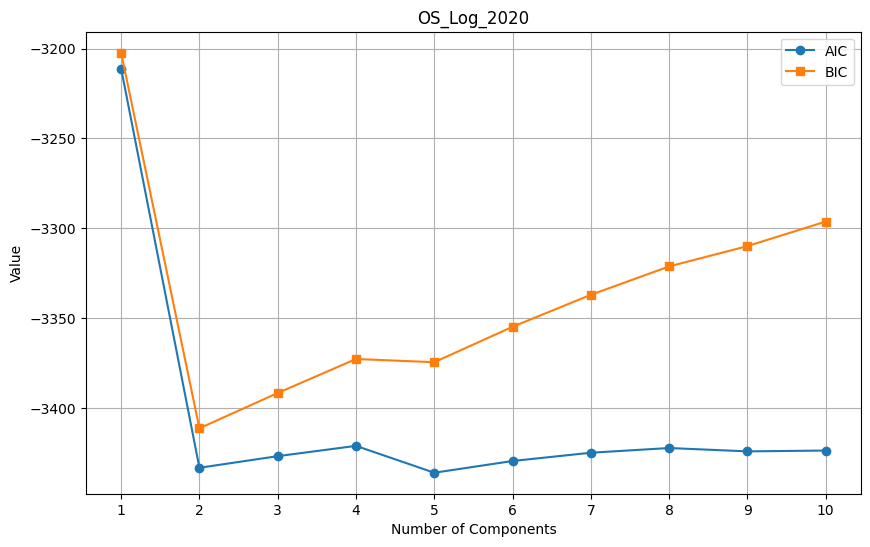

min AIC index: 4
min AIC value: -3436.057956062866
min BIC index: 1
min BIC values: -3411.337980717726


In [278]:
func_IS_OS(IS_log,OS_log)

In [279]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import moment, skew, kurtosis

def GMM_AIC_BIC(data, title):
    aic_values = []
    bic_values = []
    X = data.reshape(-1, 1)  # 데이터 형태 조정 (1D 배열을 2D 배열로)
    
    # 클러스터 개수를 변경하면서 AIC와 BIC 값을 계산합니다.
    for n_components in range(1, 11):
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        aic_values.append(gmm.aic(X))
        bic_values.append(gmm.bic(X))
    
    # AIC와 BIC 플롯
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), aic_values, marker='o', label='AIC')
    plt.plot(range(1, 11), bic_values, marker='s', label='BIC')
    plt.xlabel('Number of Components')
    plt.ylabel('Value')
    plt.title(title)
    plt.xticks(range(1, 11))
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 최적의 n_components 찾기
    best_n_components = np.argmin(bic_values) + 1  # AIC 기준으로 최적의 n_components 선택
    print('Best number of components (AIC):', best_n_components)
    print('min AIC value:', np.min(aic_values))
    print('min BIC value:', np.min(bic_values))

    # 최적의 GMM 모델로 데이터 적합
    best_gmm = GaussianMixture(n_components=best_n_components)
    best_gmm.fit(X)
    
    # 히스토그램과 GMM 분포 플롯
    plt.figure(figsize=(10, 6))
    plt.hist(X, bins=30, density=True, alpha=0.6, color='g', label='Histogram')
    
    # GMM의 각 가우시안 분포를 플롯
    x = np.linspace(min(X), max(X), 1000).reshape(-1, 1)
    logprob = best_gmm.score_samples(x)
    pdf = np.exp(logprob)
    plt.plot(x, pdf, '-k', label='GMM')
    
    # 각 개별 가우시안 분포 플롯
    responsibilities = best_gmm.predict_proba(x)
    pdf_individuals = responsibilities * pdf[:, np.newaxis]
    for i in range(best_n_components):
        plt.plot(x, pdf_individuals[:, i], '--', label=f'Component {i+1}')
    
    plt.title(f'{title} with {best_n_components} Components')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 1차부터 4차 적률 계산 및 출력
    mean = np.mean(data)
    variance = np.var(data)
    skewness = skew(data)
    kurt = kurtosis(data, fisher=False)  # Fisher=False to get Pearson's kurtosis
    
    print(f"1st Moment (Mean): {mean}")
    print(f"2nd Moment (Variance): {variance}")
    print(f"3rd Moment (Skewness): {skewness}")
    print(f"4th Moment (Kurtosis): {kurt}")

def func_IS_OS(IS, OS):
    GMM_AIC_BIC(IS, 'IS_2020')
    GMM_AIC_BIC(OS, 'OS_Log_2020')

# 예시 데이터로 실행
# IS = np.random.normal(0, 1, 1000)
# OS = np.random.normal(3, 2, 1000)
# func_IS_OS(IS, OS)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 


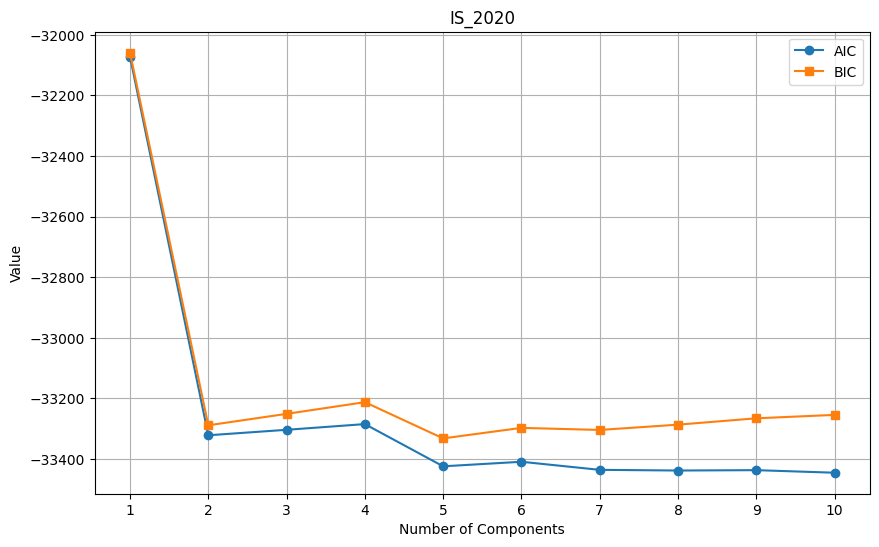

Best number of components (AIC): 5
min AIC value: -33445.41194535586
min BIC value: -33332.14878912643


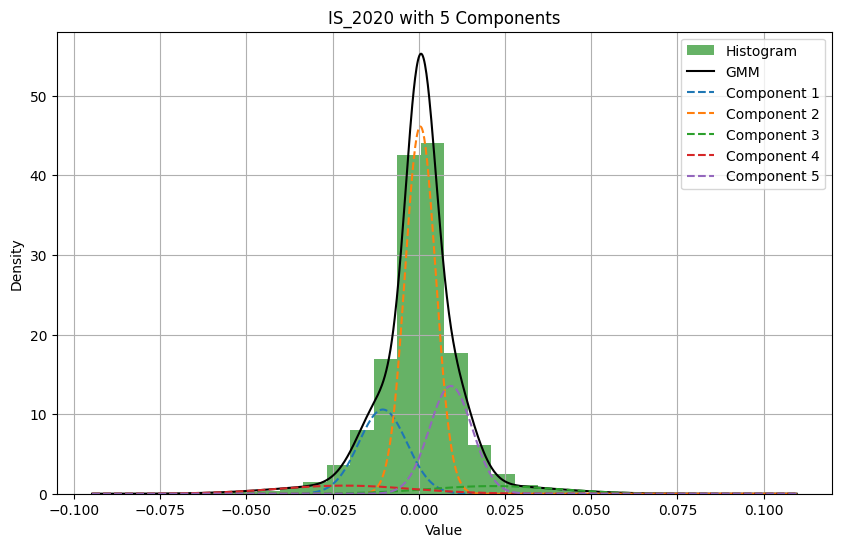

1st Moment (Mean): 0.00017335661764448119
2nd Moment (Variance): 0.0001413927283648935
3rd Moment (Skewness): [-0.22130509]
4th Moment (Kurtosis): [11.24219568]


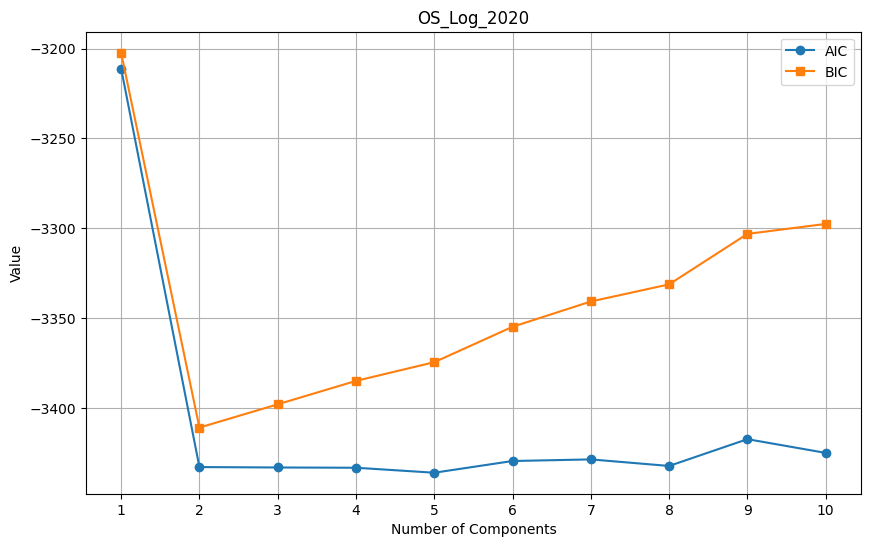

Best number of components (AIC): 2
min AIC value: -3436.057956062866
min BIC value: -3410.94157286431


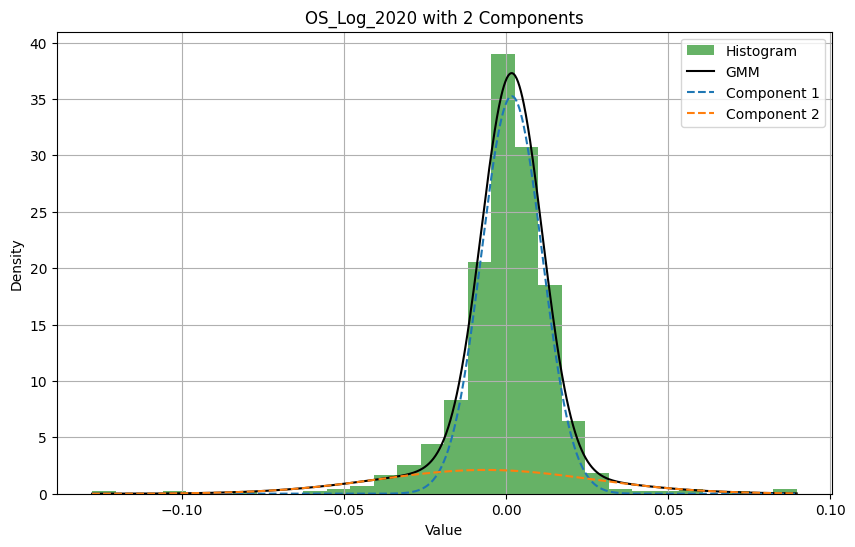

1st Moment (Mean): 0.00037331097522709175
2nd Moment (Variance): 0.00027074548187091814
3rd Moment (Skewness): [-0.91894658]
4th Moment (Kurtosis): [15.34493465]


In [280]:
func_IS_OS(IS_log,OS_log)

----

## Simulation model

### MCMC 모델링

In [ ]:
def GBM_PDF(s,mu,sigma,S0,t=1):
    import numpy as np
    """
    기하 브라운 운동의 확률 밀도 함수를 계산

    Parameters:
    s (float): 자산 가격
    S0 (float): 초기 자산 가격
    mu (float): 드리프트(평균 성장률)
    sigma (float): 변동성(표준 편차)
    t (float): 시간
    """
    if s <= 0 or t <= 0:
        return 0.0
    
    term1 = 1 / (s * sigma * np.sqrt(2 * np.pi * t))
    exponent = -(np.log(s / S0) - (mu - 0.5 * sigma**2) * t)**2 / (2 * sigma**2 * t)
    term2 = np.exp(exponent)
    
    return term1 * term2


In [ ]:
def log_likelihood(mu_proposal, sigma_proposal, data):

    MLE_list = []
    
    data_1 = data[1:]
    for i,data_1 in enumerate(data_1):
        data_inital = data[i]
        MLE_list.append(np.log(GBM_PDF(data_1,mu_proposal,sigma_proposal,data_inital)))
    return np.sum(MLE_list)

def metropolis_hastings(data, initial_params,iterations, proposal_width):
    mu_current, sigma_current = initial_params
    samples = []
    for _ in range(iterations):
        mu_proposal = np.random.normal(mu_current, proposal_width)
        sigma_proposal = np.abs(np.random.normal(sigma_current, proposal_width))
        
        # Calculate log-likelihoods
        ll_current = log_likelihood(mu_current, sigma_current, data)
        ll_proposal = log_likelihood(mu_proposal, sigma_proposal+0.0000001, data)
        
        # Calculate acceptance probability
        acceptance_prob = min(1, np.exp(ll_proposal - ll_current))
        
        # Accept or reject the proposal
        if np.random.rand() < acceptance_prob:
            mu_current = mu_proposal
            sigma_current = sigma_proposal
        
        samples.append((mu_current, sigma_current))
    
    return np.array(samples)

In [ ]:
def estimated_para(data,initial_params,iterations,proposal_width):
    samples = metropolis_hastings(data, initial_params, iterations, proposal_width)

    # Extract and plot samples
    mu_samples = samples[:, 0]
    sigma_samples = samples[:, 1]

    estimated_mu = np.mean(mu_samples[int(iterations-iterations*0.4):iterations])
    estimated_sigma = np.mean(sigma_samples[int(iterations-iterations*0.4):iterations])
    return estimated_mu,estimated_sigma,mu_samples,sigma_samples
def ploting_para(estimated_mu,estimated_sigma,mu_samples,sigma_samples):
    print(f"Estimated mu: {estimated_mu}")
    print(f"Estimated sigma: {estimated_sigma}")

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    ax[0].plot(mu_samples, label='mu samples')

    ax[0].legend()

    ax[1].plot(sigma_samples, label='sigma samples')

    ax[1].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
IS = data.iloc[:int(len(data)*0.8)]['Adj Close']
OS = data.iloc[int(len(data)*0.8):]['Adj Close']
IS_OS = data['Adj Close']

In [ ]:
initial_params = [0, 0.1]
iterations = 10000
proposal_width = 0.1

estimated_mu_IS_OS,estimated_sigma_IS_OS,mu_samples_IS_OS,sigma_samples_IS_OS = estimated_para(IS_OS,initial_params,iterations,proposal_width)
estimated_mu_OS,estimated_sigma_OS,mu_samples_OS,sigma_samples_OS = estimated_para(OS,initial_params,iterations,proposal_width)
estimated_mu_IS,estimated_sigma_IS,mu_samples_IS,sigma_samples_IS = estimated_para(IS,initial_params,iterations,proposal_width)


/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_24546/1553238095.py:23: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1, np.exp(ll_proposal - ll_current))
/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_24546/1553238095.py:8: RuntimeWarning: divide by zero encountered in log
  MLE_list.append(np.log(GBM_PDF(data_1,mu_proposal,sigma_proposal,data_inital)))


KeyboardInterrupt: 

Estimated mu: 0.0022081326733347246
Estimated sigma: 0.013308661015540416


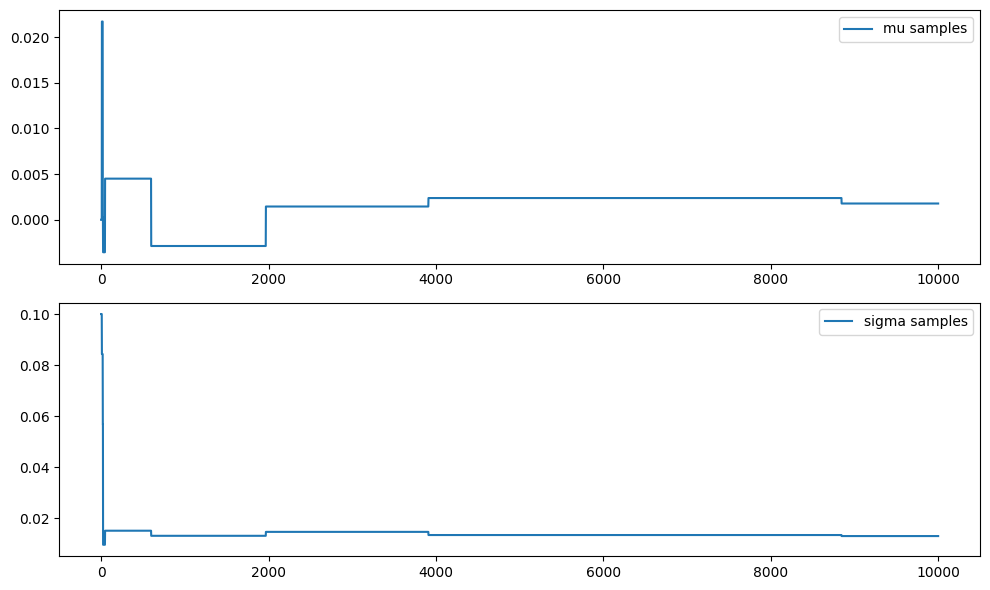

In [ ]:
ploting_para(estimated_mu_IS_OS,estimated_sigma_IS_OS,mu_samples_IS_OS,sigma_samples_IS_OS)

In [ ]:
import numpy as np
from scipy.stats import chi2
def para_hypo_test(estimated_mu_H0,estimated_sigma_H0,estimated_mu_H1,estimated_sigma_H1,OS):
    data = OS
    mu_0 = estimated_mu_H0
    sigma_0 = estimated_sigma_H0

    # MLE estimates from the sample
    mu_hat = estimated_mu_H1
    sigma_hat = estimated_sigma_H1

    
    # Log-likelihoods
    ll_null = log_likelihood(mu_0, sigma_0, data)
    ll_alternative = log_likelihood(mu_hat, sigma_hat, data)

    # Likelihood ratio test statistic
    likelihood_ratio = -2 * (ll_null - ll_alternative)

    # Critical value for chi-squared distribution with 2 degrees of freedom
    alpha = 0.1
    degrees_of_freedom = 1
    critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

    print("Likelihood Ratio Test Statistic:", likelihood_ratio)
    print("Critical Value (chi-squared with df=1):", critical_value)

    if likelihood_ratio > critical_value:
        print("Reject the null hypothesis.")
        return 
    else:
        print("Fail to reject the null hypothesis.")
    


In [ ]:
# IS = weekly_data.iloc[500:1000,1]
# OS = weekly_data.iloc[1000:1500,1]
# IS_OS = weekly_data.iloc[500:1500,1]
# IS, OS,IS_OS ,IS_log, OS_log, IS_OS_log = cal_period(position = daily_data.index.get_loc('2020-01-02 00:00:00'))
# estimated_mu_IS_OS,estimated_sigma_IS_OS,mu_samples_IS_OS,sigma_samples_IS_OS = estimated_para(IS_OS,initial_params,iterations,proposal_width)
# estimated_mu_OS,estimated_sigma_OS,mu_samples_OS,sigma_samples_OS = estimated_para(OS,initial_params,iterations,proposal_width)
# estimated_mu_IS,estimated_sigma_IS,mu_samples_IS,sigma_samples_IS = estimated_para(IS,initial_params,iterations,proposal_width)


NameError: name 'estimated_mu_IS' is not defined

In [ ]:
para_hypo_test(estimated_mu_IS,estimated_sigma_IS,estimated_mu_IS_OS,estimated_sigma_IS_OS,IS_OS)

NameError: name 'estimated_mu_IS' is not defined

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
def ols_function(data_1):
  


    # 특징과 타겟 생성 (예: 과거 5일 수익률을 사용)
    
    X, y = data_1[:-1],data_1[1:]

    

    # ===========================
    # 데이터 분할 (Train/Test)
    # ===========================

    # 데이터 분할 (80% 훈련, 20% 테스트)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    


    # ===========================
    # OLS 모델 학습 및 예측
    # ===========================

    # OLS 모델 학습
    ols_model = LinearRegression()
    ols_model.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
    # 훈련 세트 예측
    y_train_pred = ols_model.predict(X_train.reshape(-1,1))

    # 테스트 세트 예측
    y_test_pred = ols_model.predict(X_test.reshape(-1,1))

    # ===========================
    # 모델 평가 (MSE 계산) 및 비교
    # ===========================

    # 훈련 세트 MSE 계산
    mse_train = mean_squared_error(y_train.reshape(-1,1), y_train_pred.reshape(-1,1))
    

    # 테스트 세트 MSE 계산
    mse_test = mean_squared_error(y_test.reshape(-1,1), y_test_pred.reshape(-1,1))


    # MSE 차이 계산
    
    return mse_train,mse_test



In [33]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings


def create_sequences(data, n_lags=5):
    """
    과거 n_lags일간의 데이터를 사용하여 다음 값을 예측하기 위한 시퀀스 데이터를 생성합니다.
    
    Parameters:
    - data: numpy array 또는 pandas Series (수익률 데이터)
    - n_lags: int (과거 며칠간의 데이터를 사용할지 결정)
    
    Returns:
    - sequences: list of numpy arrays (시퀀스 데이터)
    - targets: list of floats (타겟 데이터)
    """
    sequences = []
    targets = []
    for i in range(n_lags, len(data)):
        seq = data[i - n_lags:i]
        target = data[i]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        """
        LSTM 모델을 정의합니다.
        
        Parameters:
        - input_size: int (입력 피처의 수)
        - hidden_size: int (LSTM의 은닉 상태 크기)
        - num_layers: int (LSTM 레이어의 수)
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM 레이어
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully Connected 레이어
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        """
        순전파를 정의합니다.
        
        Parameters:
        - x: torch.Tensor (입력 데이터)
        
        Returns:
        - out: torch.Tensor (출력)
        """
        # 초기 은닉 상태와 셀 상태 (0으로 초기화)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM 순전파
        out, _ = self.lstm(x, (h0, c0))  # out: (batch, seq_len, hidden_size)
        
        # 마지막 타임스텝의 출력만 사용
        out = out[:, -1, :]
        
        # Fully Connected 레이어 통과
        out = self.fc(out)
        return out

def lstm_function(data_1, n_lags=5, num_epochs=100, batch_size=32, learning_rate=0.001, hidden_size=50, num_layers=1):
    """
    LSTM 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.
    
    Parameters:
    - data_1: numpy array (수익률 데이터)
    - n_lags: int (과거 며칠간의 데이터를 사용할지 결정)
    - num_epochs: int (학습 에포크 수)
    - batch_size: int (배치 크기)
    - learning_rate: float (학습률)
    - hidden_size: int (LSTM 은닉 상태 크기)
    - num_layers: int (LSTM 레이어 수)
    
    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    # 시퀀스 데이터 생성
    X, y = create_sequences(data_1, n_lags=n_lags)
    
    # 데이터 스케일링
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    # 데이터 분할 (80% 훈련, 20% 테스트)
    train_size = int(len(X_scaled) * 0.8)
    X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
    y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
    
    
    # Tensor 변환
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, features)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    # Dataset 및 DataLoader 생성
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 모델 초기화
    device = torch.device("mps" if torch.cuda.is_available() else "cpu")
    model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=num_layers).to(device)
    
    # 손실 함수 및 옵티마이저
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # 학습 과정
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # 순전파
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # 예측 함수
    def predict(loader):
        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                predictions.append(outputs.cpu().numpy())
                actuals.append(y_batch.cpu().numpy())
        return np.concatenate(predictions).flatten(), np.concatenate(actuals).flatten()
    
    # 훈련 세트 예측
    y_train_pred_scaled, y_train_actual_scaled = predict(train_loader)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_train_actual = scaler_y.inverse_transform(y_train_actual_scaled.reshape(-1, 1)).flatten()
    
    # 테스트 세트 예측
    y_test_pred_scaled, y_test_actual_scaled = predict(test_loader)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    y_test_actual = scaler_y.inverse_transform(y_test_actual_scaled.reshape(-1, 1)).flatten()
    
    # MSE 계산
    mse_train = mean_squared_error(y_train_actual, y_train_pred)
    mse_test = mean_squared_error(y_test_actual, y_test_pred)
    
    return mse_train, mse_test

## 예측 모델

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# 시계열 모델링을 위한 statsmodels 및 arch 임포트
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import pmdarima as pm 


def ar_model_function(data, lags=1):
    """
    AR (AutoRegressive) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - lags: int (AR 모델의 시차)

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # AR 모델 학습
    try:
        model = AutoReg(train_data, lags=lags).fit()
    except Exception as e:
        print(f"AR 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.predict(start=0, end=len(train_data)-1, dynamic=False)
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"AR 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.predict(start=len(train_data), end=len(data)-1, dynamic=False)
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"AR 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test

def ma_model_function(data, lags=1):
    """
    MA (Moving Average) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - lags: int (MA 모델의 시차)

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # MA 모델 학습 (ARIMA의 MA 파트만 사용)
    try:
        model = ARIMA(train_data, order=(0,0,lags)).fit()
    except Exception as e:
        print(f"MA 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.predict(start=0, end=len(train_data)-1, dynamic=False)
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"MA 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.predict(start=len(train_data), end=len(data)-1, dynamic=False)
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"MA 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test

def arma_model_function(data, order=(1,1)):
    """
    ARMA (AutoRegressive Moving Average) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - order: tuple (p, q) ARMA 모델의 파라미터

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    p, q = order
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # ARMA 모델 학습
    try:
        model = ARIMA(train_data, order=(p,0,q)).fit()
    except Exception as e:
        print(f"ARMA 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.predict(start=0, end=len(train_data)-1, dynamic=False)
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"ARMA 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.predict(start=len(train_data), end=len(data)-1, dynamic=False)
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"ARMA 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test


def arima_model_function(data, order=(1,1,1)):
    """
    ARIMA (AutoRegressive Integrated Moving Average) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - order: tuple (p, d, q) ARIMA 모델의 파라미터

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    p, d, q = order
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # ARIMA 모델 학습
    try:
        model = ARIMA(train_data, order=order).fit()
    except Exception as e:
        print(f"ARIMA 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.predict(start=0, end=len(train_data)-1, dynamic=False)
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"ARIMA 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.predict(start=len(train_data), end=len(data)-1, dynamic=False)
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"ARIMA 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test


def sarima_model_function(data, order=(1,1,1), seasonal_order=(1,1,1,12)):
    """
    SARIMA (Seasonal ARIMA) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - order: tuple (p, d, q) ARIMA 모델의 비계절적 파라미터
    - seasonal_order: tuple (P, D, Q, s) 계절적 파라미터

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    p, d, q = order
    P, D, Q, s = seasonal_order
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # SARIMA 모델 학습
    try:
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order).fit(disp=False)
    except Exception as e:
        print(f"SARIMA 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.predict(start=0, end=len(train_data)-1, dynamic=False)
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"SARIMA 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.predict(start=len(train_data), end=len(data)-1, dynamic=False)
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"SARIMA 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test


def arch_model_function(data, vol='ARCH', p=1):
    """
    ARCH (Autoregressive Conditional Heteroskedasticity) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - vol: str (변동성 모델 종류, 기본값 'ARCH')
    - p: int (이전 시점의 변동성의 영향 정도)

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # ARCH 모델 학습
    try:
        model = arch_model(train_data, vol=vol, p=p, o=0, q=0).fit(disp='off')
    except Exception as e:
        print(f"ARCH 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.conditional_volatility
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"ARCH 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.forecast(horizon=len(test_data)).mean['h.1'].values
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"ARCH 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test

def garch_model_function(data, vol='GARCH', p=1, q=1):
    """
    GARCH (Generalized ARCH) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - vol: str (변동성 모델 종류, 기본값 'GARCH')
    - p: int (GARCH 모델의 ARCH 파트 시차)
    - q: int (GARCH 모델의 GARCH 파트 시차)

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # GARCH 모델 학습
    try:
        model = arch_model(train_data, vol=vol, p=p, o=0, q=q).fit(disp='off')
    except Exception as e:
        print(f"GARCH 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.conditional_volatility
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"GARCH 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.forecast(horizon=len(test_data)).mean['h.1'].values
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"GARCH 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test


def arfima_model_function(data, seasonal=False, m=1):
    """
    ARFIMA (AutoRegressive Fractionally Integrated Moving Average) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - seasonal: bool (계절성 여부, 기본값 False)
    - m: int (계절 주기, 기본값 1)

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    - order: tuple (p, d, q) 최적 ARIMA 파라미터
    """
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # auto_arima를 사용하여 최적의 ARFIMA 모델 파라미터 찾기
    try:
        model = pm.auto_arima(train_data, seasonal=seasonal, m=m, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True, fractional=True)
        order = model.order
    except Exception as e:
        print(f"ARFIMA 모델 학습 실패: {e}")
        return np.nan, np.nan, None
    
    # ARFIMA 모델 학습
    try:
        model.fit(train_data)
    except Exception as e:
        print(f"ARFIMA 모델 학습 실패: {e}")
        return np.nan, np.nan, None
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.predict_in_sample()
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"ARFIMA 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.predict(n_periods=len(test_data))
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"ARFIMA 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test, order


def ets_model_function(data, trend='add', seasonal='add', seasonal_periods=12):
    """
    ETS (Exponential Smoothing) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - trend: str (추세 구성 요소, 기본값 'add')
    - seasonal: str (계절 구성 요소, 기본값 'add')
    - seasonal_periods: int (계절 주기, 기본값 12)

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # ETS 모델 학습
    try:
        model = sm.tsa.ExponentialSmoothing(train_data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).fit()
    except Exception as e:
        print(f"ETS 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.fittedvalues
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"ETS 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.forecast(steps=len(test_data))
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"ETS 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test


def tarch_model_function(data, p=1, q=1, o=1):
    """
    TARCH (Threshold ARCH) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - p: int (ARCH 파트의 시차)
    - q: int (GARCH 파트의 시차)
    - o: int (비대칭 파트의 시차)

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # TARCH 모델 학습
    try:
        model = arch_model(train_data, vol='TARCH', p=p, q=q, o=o).fit(disp='off')
    except Exception as e:
        print(f"TARCH 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.conditional_volatility
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"TARCH 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.forecast(horizon=len(test_data)).mean['h.1'].values
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"TARCH 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test


def egarch_model_function(data, p=1, q=1):
    """
    EGARCH (Exponential GARCH) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - p: int (ARCH 파트의 시차)
    - q: int (GARCH 파트의 시차)

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # EGARCH 모델 학습
    try:
        model = arch_model(train_data, vol='EGARCH', p=p, q=q).fit(disp='off')
    except Exception as e:
        print(f"EGARCH 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.conditional_volatility
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"EGARCH 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.forecast(horizon=len(test_data)).mean['h.1'].values
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"EGARCH 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test


def aparch_model_function(data, p=1, o=1, q=1, power=1.0):
    """
    APARCH (Asymmetric Power ARCH) 모델을 사용하여 훈련 세트와 테스트 세트의 MSE를 계산합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - p: int (ARCH 파트의 시차)
    - o: int (비대칭 파트의 시차)
    - q: int (GARCH 파트의 시차)
    - power: float (잔차의 거듭제곱)

    Returns:
    - mse_train: float (훈련 세트의 MSE)
    - mse_test: float (테스트 세트의 MSE)
    """
    # 데이터 분할 (80% 훈련, 20% 테스트)
    split_index = int(len(data) * 0.8)
    train_data, test_data = data[:split_index], data[split_index:]
    
    # APARCH 모델 학습
    try:
        model = arch_model(train_data, vol='APARCH', p=p, o=o, q=q, power=power).fit(disp='off')
    except Exception as e:
        print(f"APARCH 모델 학습 실패: {e}")
        return np.nan, np.nan
    
    # 훈련 세트 예측 (in-sample prediction)
    try:
        train_pred = model.conditional_volatility
        mse_train = mean_squared_error(train_data, train_pred)
    except Exception as e:
        print(f"APARCH 모델 훈련 세트 예측 실패: {e}")
        mse_train = np.nan
    
    # 테스트 세트 예측 (out-of-sample prediction)
    try:
        test_pred = model.forecast(horizon=len(test_data)).mean['h.1'].values
        mse_test = mean_squared_error(test_data, test_pred)
    except Exception as e:
        print(f"APARCH 모델 테스트 세트 예측 실패: {e}")
        mse_test = np.nan
    
    return mse_train, mse_test

## Hypo test

In [ ]:
from scipy.stats import f

from scipy.stats import ttest_ind

def t_test(train_data, test_data):
    """
    두 기간 간의 기대 수익률의 평균이 동일한지를 검정하는 T-검정 함수.
    
    Parameters:
    - mu1: 첫 번째 기간의 수익률 (numpy array)
    - mu2: 두 번째 기간의 수익률 (numpy array)
    - alpha: 유의수준 (float)
    
    Returns:
    - reject: 귀무가설 기각 여부 (bool)
    - p_value: p-값 (float)
    """
    mu1 = train_data.pct_change()['Adj Close'].mean()
    mu2 = test_data.pct_change()['Adj Close'].mean()
    t_stat, p_val = ttest_ind(mu1, mu2, equal_var=False)
    return t_stat, p_val

def f_test(train_data,sample):
    """
    두 기간 간의 공분산 행렬이 동일한지를 검정하는 F-검정 함수.
    
    Parameters:
    - cov1: 첫 번째 기간의 공분산 행렬 (numpy array)
    - cov2: 두 번째 기간의 공분산 행렬 (numpy array)
    - alpha: 유의수준 (float)
    
    Returns:
    - reject: 귀무가설 기각 여부 (bool)
    - p_value: p-값 (float)
    """
    cov1 = train_data.corr()
    cov2 = sample.corr()
    # 공분산 행렬의 determinant를 이용한 F-검정
    det1 = np.linalg.det(cov1)
    det2 = np.linalg.det(cov2)
    F_stat = det1 / det2
    df1 = cov1.shape[0]
    df2 = cov2.shape[0]
    p_val = 1 - chi2.cdf(F_stat, df1)
    
    return F_stat, p_val

def hotelling_t2_test(mu1, cov1, mu2, cov2, n1, n2, alpha=0.05):
    """
    Hotelling’s T-squared 검정을 수행하여 두 기간 간의 다변량 평균이 동일한지를 검정합니다.
    
    Parameters:
    - mu1: 첫 번째 기간의 기대 수익률 (numpy array)
    - cov1: 첫 번째 기간의 공분산 행렬 (numpy array)
    - mu2: 두 번째 기간의 기대 수익률 (numpy array)
    - cov2: 두 번째 기간의 공분산 행렬 (numpy array)
    - n1: 첫 번째 기간의 샘플 수 (int)
    - n2: 두 번째 기간의 샘플 수 (int)
    - alpha: 유의수준 (float)
    
    Returns:
    - reject: 귀무가설 기각 여부 (bool)
    - p_value: p-값 (float)
    """
    p = len(mu1)
    pooled_cov = ((n1 - 1) * cov1 + (n2 - 1) * cov2) / (n1 + n2 - 2)
    diff = mu1 - mu2
    T2 = (n1 * n2) / (n1 + n2) * diff.T @ np.linalg.inv(pooled_cov) @ diff
    F_stat = (n1 + n2 - p - 1) * T2 / ((n1 + n2 - 2) * p)
    p_val = 1 - f.cdf(F_stat, p, n1 + n2 - p - 1)
    reject = p_val < alpha
    return reject, p_val

from scipy.stats import ks_2samp

def ks_test(data1, data2, alpha=0.05):
    """
    Kolmogorov-Smirnov 검정을 수행하여 두 데이터 샘플의 분포가 동일한지를 검정합니다.
    
    Parameters:
    - data1: 첫 번째 데이터 샘플 (numpy array)
    - data2: 두 번째 데이터 샘플 (numpy array)
    - alpha: 유의수준 (float)
    
    Returns:
    - reject: 귀무가설 기각 여부 (bool)
    - p_value: p-값 (float)
    """
    ks_stat, p_val = ks_2samp(data1, data2)
    reject = p_val < alpha
    return reject, p_val

In [50]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

[*********************100%%**********************]  1 of 1 completed
100%|██████████| 3000/3000 [38:06<00:00,  1.31it/s]   


총 3000번의 샘플링 중 귀무가설이 기각된 횟수: 526
기각률: 17.53%

MSE 비교:
H0 기각된 경우 - 평균 MSE: 464.453195, 중위수 MSE: 0.001518
H0 기각되지 않은 경우 - 평균 MSE: 31.174894, 중위수 MSE: 0.001502


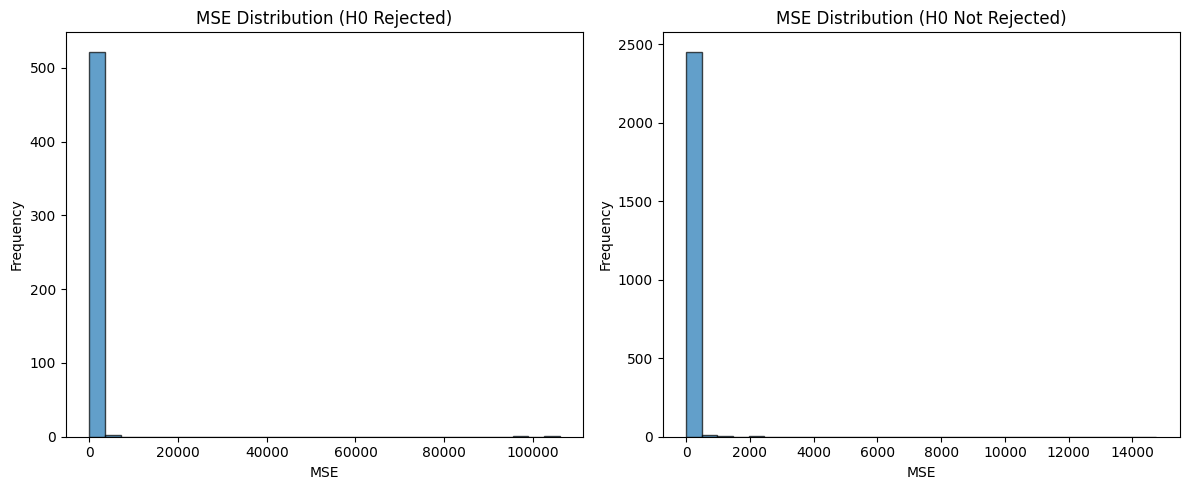

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import chi2
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

import yfinance as yf
# GBM 확률 밀도 함수
def GBM_PDF(S_t, mu, sigma, S_0, dt=1):
    if S_t <= 0 or S_0 <= 0 or sigma <= 0:
        return 1e-10  # 작은 값 반환
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    exponent = -(np.log(S_t / S_0) - drift)**2 / (2 * diffusion**2)
    pdf = (1 / (S_t * diffusion * np.sqrt(2 * np.pi))) * np.exp(exponent)
    return pdf

# 로그 우도 함수
def log_likelihood(mu_proposal, sigma_proposal, data):
    MLE_list = []
    data_1 = data[1:]
    for i, S_t in enumerate(data_1):
        S_0 = data[i]
        likelihood = GBM_PDF(S_t, mu_proposal, sigma_proposal, S_0)
        if likelihood <= 0 or np.isnan(likelihood):
            return -np.inf  # 로그 우도가 무한대로 발산하지 않도록 처리
        MLE_list.append(np.log(likelihood))
    return np.sum(MLE_list)

# 음의 로그 우도 함수
def negative_log_likelihood(params, data):
    mu_proposal, sigma_proposal = params
    if sigma_proposal <= 0:
        return np.inf
    nll = -log_likelihood(mu_proposal, sigma_proposal, data)
    return nll

# 로그 수익률 계산 함수
def log_return_cal(price):
    log_returns = np.log(price[1:] / price[:-1])
    return log_returns

# 모수 최적화 함수
def optimization_likelihood_para(price):
    data = price.values
    log_returns = log_return_cal(data)
    initial_guess = [log_returns.mean(), log_returns.std()]
    bounds = [(-1, 1), (1e-6, 1)]  # sigma는 양수
    result = minimize(negative_log_likelihood, initial_guess, args=(data,), bounds=bounds)
    mu_est, sigma_est = result.x
    return mu_est, sigma_est

# GBM 시뮬레이션 함수
def simulate_gbm(s0, mu, sigma, T, n_steps):
    dt = T / n_steps
    time = np.linspace(0, T, n_steps + 1)
    W = np.random.normal(0, np.sqrt(dt), size=n_steps).cumsum()
    W = np.insert(W, 0, 0)  # 시작점 추가
    S = s0 * np.exp((mu - 0.5 * sigma**2) * time + sigma * W)
    return S

# 우도비 검정 수행 함수
def likelihood_ratio_test(data_full, mu_full, sigma_full, data_sample, mu_sample, sigma_sample):
    # 제한 모형: 전체 데이터의 모수를 사용하여 샘플 데이터의 로그 우도 계산
    ll_restricted = log_likelihood(mu_full, sigma_full, data_sample)
    # 대안 모형: 샘플 데이터의 모수를 사용하여 샘플 데이터의 로그 우도 계산
    ll_unrestricted = log_likelihood(mu_sample, sigma_sample, data_sample)
    # 우도비 통계량 계산
    LR_stat = 2 * (ll_unrestricted - ll_restricted)
    df = 2  # 모수의 차이 수 (μ와 σ)
    # p-value 계산
    p_value = 1 - chi2.cdf(LR_stat, df)
    return LR_stat, p_value
def create_features_targets(data, n_lags=5):
    """
    n_lags일간의 수익률을 특징으로 사용하여 다음날의 수익률을 타겟으로 설정합니다.
    
    Parameters:
    - data: pandas Series 또는 numpy array (수익률 데이터)
    - n_lags: int (과거 며칠간의 데이터를 사용할지 결정)
    
    Returns:
    - X: numpy array (특징)
    - y: numpy array (타겟)
    """
    features = []
    targets = []
    
    for i in range(n_lags, len(data)):
        feature = data[i-n_lags:i]
        target = data[i]
        features.append(feature)
        targets.append(target)
    
    X = np.array(features)
    y = np.array(targets)
    return X, y

from tqdm import tqdm 


def GBM_Hypo(train_data,sample):


    mu_sample, sigma_sample = optimization_likelihood_para(train_data['Adj Close'])
    mu_full, sigma_full = optimization_likelihood_para(sample['Adj Close'])
    

    # 우도비 검정 수행
    LR_stat, p_value = likelihood_ratio_test(
        data['Adj Close'].values, mu_full, sigma_full,
        train_data['Adj Close'].values, mu_sample, sigma_sample
        )
    return LR_stat, p_value
# 메인 함수: 샘플링 및 가설 검정 수행
def sample_and_test(data, sample_size=252, num_samples=1000, alpha=0.05):
    # 전체 데이터에서 모수 추정
   

    max_start_index = len(data) - sample_size  # 시작 인덱스의 최대값

    reject_count = 0  # 귀무가설이 기각된 횟수
    mse_values = []  # MSE 값 저장
    reject_flags = []  # 귀무가설 기각 여부 저장

    for i in tqdm(range(num_samples)):
        # 시작 인덱스를 랜덤하게 선택
        start_index = np.random.randint(0, max_start_index + 1)
        end_index = start_index + sample_size

        # 연속된 기간의 데이터 추출
        sample = data.iloc[start_index:end_index]

        # 데이터 분할 (80% 훈련, 20% 테스트)
        split_index = int(len(sample) * 0.8)
        train_data = sample.iloc[:split_index]
        test_data = sample.iloc[split_index:]

        # 샘플 데이터에서 모수 추정
        # try:
        #     mu_sample, sigma_sample = optimization_likelihood_para(train_data['Adj Close'])
        #     mu_full, sigma_full = optimization_likelihood_para(sample['Adj Close'])
            
        # except:
        #     continue  # 최적화 실패 시 다음 반복으로 넘어감
        # # 우도비 검정 수행
        # LR_stat, p_value = likelihood_ratio_test(
        #     data['Adj Close'].values, mu_full, sigma_full,
        #     train_data['Adj Close'].values, mu_sample, sigma_sample
        # )
        # stat, p_value = GBM_Hypo(train_data,sample)
        # stat, p_value = t_test(train_data,sample)
        stat, p_value = f_test(train_data,sample)
        # 유의수준 alpha에서 귀무가설 기각 여부 판단
        if p_value < alpha:
            reject_flags.append(True)
            reject_count += 1
        else:
            reject_flags.append(False)
        
        data_1 = sample['Adj Close'].dropna().values
        train_mse, test_mse = lstm_function(data_1) 
        # 훈련 데이터의 모수로 테스트 데이터 예측 및 MSE 계산
        
        mse_test = np.mean((train_mse - test_mse)**2)
        mse_values.append(mse_test)

    # 귀무가설 기각 여부에 따른 MSE 값 분류
    mse_reject = [mse for mse, flag in zip(mse_values, reject_flags) if flag]
    mse_not_reject = [mse for mse, flag in zip(mse_values, reject_flags) if not flag]

    # 결과 출력
    total_samples = len(mse_values)
    print(f"\n총 {total_samples}번의 샘플링 중 귀무가설이 기각된 횟수: {reject_count}")
    print(f"기각률: {reject_count / total_samples * 100:.2f}%")

    # MSE의 평균 및 중위수 비교
    if mse_reject:
        mean_reject = np.mean(mse_reject)
        median_reject = np.median(mse_reject)
    else:
        mean_reject = median_reject = None

    if mse_not_reject:
        mean_not_reject = np.mean(mse_not_reject)
        median_not_reject = np.median(mse_not_reject)
    else:
        mean_not_reject = median_not_reject = None

    print("\nMSE 비교:")
    if mean_reject is not None:
        print(f"H0 기각된 경우 - 평균 MSE: {mean_reject:.6f}, 중위수 MSE: {median_reject:.6f}")
    else:
        print("H0 기각된 경우가 없습니다.")

    if mean_not_reject is not None:
        print(f"H0 기각되지 않은 경우 - 평균 MSE: {mean_not_reject:.6f}, 중위수 MSE: {median_not_reject:.6f}")
    else:
        print("H0 기각되지 않은 경우가 없습니다.")

    # MSE 분포 비교 시각화
    plt.figure(figsize=(12, 5))
    if mse_reject:
        plt.subplot(1, 2, 1)
        plt.hist(mse_reject, bins=30, edgecolor='k', alpha=0.7)
        plt.title('MSE Distribution (H0 Rejected)')
        plt.xlabel('MSE')
        plt.ylabel('Frequency')

    if mse_not_reject:
        plt.subplot(1, 2, 2)
        plt.hist(mse_not_reject, bins=30, edgecolor='k', alpha=0.7)
        plt.title('MSE Distribution (H0 Not Rejected)')
        plt.xlabel('MSE')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    ratio = reject_count / total_samples

    return ratio,mean_reject, median_reject,mean_not_reject, median_not_reject,mse_reject,mse_not_reject

# 데이터 로드 (예시 데이터 사용)

data = yf.download('aapl', start="1999-01-01", end="2024-01-01")#interval='1wk'

# 샘플링 및 가설 검정 수행
ratio,mean_reject, median_reject,mean_not_reject, median_not_reject,mse_reject,mse_not_reject = sample_and_test(data, sample_size=252, num_samples=10000, alpha=0.05)

In [ ]:
def load_and_prepare_data(ticker='AAPL', start_date='1999-01-01', end_date='2024-01-01'):
    """
    Yahoo Finance에서 데이터를 다운로드하고 일일 수익률을 계산합니다.

    Parameters:
    - ticker: str (종목 티커, 기본값 'AAPL')
    - start_date: str (시작 날짜, 기본값 '1999-01-01')
    - end_date: str (종료 날짜, 기본값 '2024-01-01')

    Returns:
    - returns: pandas Series (일일 수익률 데이터)
    """
    # 데이터 다운로드
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # 결측치 제거
    data.dropna(inplace=True)
    
    # 일일 수익률 계산
    returns = data['Adj Close'].pct_change().dropna()
    
    return returns

# ===========================
# 모델 비교 함수
# ===========================

def compare_models(data, models):
    """
    다양한 시계열 모델을 적용하여 MSE를 비교합니다.

    Parameters:
    - data: pandas Series (수익률 데이터)
    - models: dict (모델 이름과 해당 함수의 딕셔너리)

    Returns:
    - results: pandas DataFrame (모델별 훈련 및 테스트 MSE)
    """
    results = {'Model': [], 'MSE_Train': [], 'MSE_Test': []}
    
    for model_name, model_func in models.items():
        print(f"모델: {model_name}")
        mse_train, mse_test = model_func(data)
        results['Model'].append(model_name)
        results['MSE_Train'].append(mse_train)
        results['MSE_Test'].append(mse_test)
        print(f"훈련 세트 MSE: {mse_train:.6f}, 테스트 세트 MSE: {mse_test:.6f}\n")
    
    results_df = pd.DataFrame(results)
    return results_df

# ===========================
# 전체 실행 예제
# ===========================

if __name__ == "__main__":
    # 데이터 로드
    returns = load_and_prepare_data(ticker='AAPL', start_date='1999-01-01', end_date='2024-01-01')
    
    # 모델 딕셔너리 정의
    models = {
        'AR(1)': lambda data: ar_model_function(data, lags=1),
        'MA(1)': lambda data: ma_model_function(data, lags=1),
        'ARMA(1,1)': lambda data: arma_model_function(data, order=(1,1)),
        'ARIMA(1,1,1)': lambda data: arima_model_function(data, order=(1,1,1)),
        'SARIMA(1,1,1)x(1,1,1,12)': lambda data: sarima_model_function(data, order=(1,1,1), seasonal_order=(1,1,1,12)),
        'ARCH(1)': lambda data: arch_model_function(data, vol='ARCH', p=1),
        'GARCH(1,1)': lambda data: garch_model_function(data, vol='GARCH', p=1, q=1),
        'ARFIMA': lambda data: arfima_model_function(data, seasonal=False, m=1),
        'ETS': lambda data: ets_model_function(data, trend='add', seasonal='add', seasonal_periods=12),
        'TARCH(1,1)': lambda data: tarch_model_function(data, p=1, q=1, o=1),
        'EGARCH(1,1)': lambda data: egarch_model_function(data, p=1, q=1),
        'APARCH(1,1)': lambda data: aparch_model_function(data, p=1, o=1, q=1, power=1.0)
    }
    
    # 모델 비교
    results_df = compare_models(returns, models)
    
    # 결과 시각화
    plt.figure(figsize=(12,6))
    plt.bar(results_df['Model'], results_df['MSE_Test'], color='skyblue')
    plt.xlabel('모델')
    plt.ylabel('테스트 세트 MSE')
    plt.title('시계열 예측 모델별 테스트 세트 MSE 비교')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 결과 출력
    print("모델별 MSE 비교:")
    print(results_df)

In [ ]:
def ols_function(data_1):
    


    # 특징과 타겟 생성 (예: 과거 5일 수익률을 사용)
    
    X, y = data_1[:-1],data_1[1:]

    

    # ===========================
    # 데이터 분할 (Train/Test)
    # ===========================

    # 데이터 분할 (80% 훈련, 20% 테스트)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    


    # ===========================
    # OLS 모델 학습 및 예측
    # ===========================

    # OLS 모델 학습
    ols_model = LinearRegression()
    ols_model.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
    # 훈련 세트 예측
    y_train_pred = ols_model.predict(X_train.reshape(-1,1))

    # 테스트 세트 예측
    y_test_pred = ols_model.predict(X_test.reshape(-1,1))

    # ===========================
    # 모델 평가 (MSE 계산) 및 비교
    # ===========================

    # 훈련 세트 MSE 계산
    mse_train = mean_squared_error(y_train.reshape(-1,1), y_train_pred.reshape(-1,1))
    

    # 테스트 세트 MSE 계산
    mse_test = mean_squared_error(y_test.reshape(-1,1), y_test_pred.reshape(-1,1))


    # MSE 차이 계산
    

In [ ]:
data['Close'][:-1]

Date
1999-01-04    1228.099976
1999-01-05    1244.780029
1999-01-06    1272.339966
1999-01-07    1269.729980
1999-01-08    1275.089966
                 ...     
2023-12-21    4746.750000
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
Name: Close, Length: 6288, dtype: float64

In [ ]:
data['Close'][1:]


Date
1999-01-05    1244.780029
1999-01-06    1272.339966
1999-01-07    1269.729980
1999-01-08    1275.089966
1999-01-11    1263.880005
                 ...     
2023-12-22    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Name: Close, Length: 6288, dtype: float64

In [ ]:
data['Adj Close'].pct_change().dropna()

Date
1999-01-05    0.013582
1999-01-06    0.022140
1999-01-07   -0.002051
1999-01-08    0.004221
1999-01-11   -0.008792
                ...   
2023-12-22    0.001660
2023-12-26    0.004232
2023-12-27    0.001430
2023-12-28    0.000370
2023-12-29   -0.002826
Name: Adj Close, Length: 6288, dtype: float64

In [ ]:

def create_features_targets(data, n_lags=5):
    """
    n_lags일간의 수익률을 특징으로 사용하여 다음날의 수익률을 타겟으로 설정합니다.
    """
    features = []
    targets = []
    
    for i in range(n_lags, len(data)):
        feature = data.values[i-n_lags:i]
        target = data.values[i]
        features.append(feature)
        targets.append(target)
    
    features = np.array(features)
    targets = np.array(targets)
    return features, targets

data_1 = data['Adj Close'].pct_change().dropna()
# 특징과 타겟 생성 (예: 과거 5일 수익률을 사용)
n_lags = 5
X, y = create_features_targets(data, n_lags=n_lags)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ===========================
# 데이터 로드 및 전처리
# ===========================



# ===========================
# 특징(feature)과 타겟(target) 생성
# ===========================
def ols_function(data_1):
    def create_features_targets(data, n_lags=5):
        """
        n_lags일간의 수익률을 특징으로 사용하여 다음날의 수익률을 타겟으로 설정합니다.
        """
        features = []
        targets = []
        
        for i in range(n_lags, len(data)):
            feature = data.values[i-1]
            target = data.values[i]
            features.append(feature)
            targets.append(target)
        
        features = np.array(features)
        targets = np.array(targets)
        return features, targets


    # 특징과 타겟 생성 (예: 과거 5일 수익률을 사용)
    n_lags = 5
    X, y = create_features_targets(data_1, n_lags=n_lags)



    # ===========================
    # 데이터 분할 (Train/Test)
    # ===========================

    # 데이터 분할 (80% 훈련, 20% 테스트)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]



    # ===========================
    # OLS 모델 학습 및 예측
    # ===========================

    # OLS 모델 학습
    ols_model = LinearRegression()
    ols_model.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

    # 훈련 세트 예측
    y_train_pred = ols_model.predict(X_train.reshape(-1,1))

    # 테스트 세트 예측
    y_test_pred = ols_model.predict(X_test.reshape(-1,1))

    # ===========================
    # 모델 평가 (MSE 계산) 및 비교
    # ===========================

    # 훈련 세트 MSE 계산
    mse_train = mean_squared_error(y_train, y_train_pred)


    # 테스트 세트 MSE 계산
    mse_test = mean_squared_error(y_test, y_test_pred)


    # MSE 차이 계산
    
    return mse_train,mse_test
data_1 = data['Adj Close'][:252].pct_change().dropna()
ols_function(data_1)

(0.00013997902876958324, 8.852864055930722e-05)

In [ ]:
X_train.reshape(-1,1)

array([[-8.79150588e-03],
       [-1.92818899e-02],
       [-4.12258498e-03],
       [-1.79926139e-02],
       [ 2.56313531e-02],
       [ 7.02989734e-03],
       [ 3.69009195e-03],
       [-1.70775262e-02],
       [-8.07190364e-03],
       [ 7.17442967e-03],
       [ 1.48544372e-02],
       [-7.29852370e-03],
       [ 1.78575339e-02],
       [ 1.12773494e-02],
       [-5.18897078e-03],
       [-8.64886863e-03],
       [ 7.98735024e-03],
       [-1.85366820e-02],
       [-7.28076788e-03],
       [ 3.52589562e-03],
       [-2.22147217e-02],
       [ 6.09307653e-03],
       [ 2.49192832e-02],
       [-1.90664041e-02],
       [ 9.54369879e-03],
       [-1.43654053e-02],
       [ 1.08248978e-02],
       [ 1.56790812e-03],
       [ 2.65651335e-02],
       [-7.54603209e-04],
       [-1.39791523e-02],
       [-6.69375098e-03],
       [-5.37345856e-03],
       [-1.75229701e-03],
       [-8.62350657e-03],
       [ 1.79514580e-03],
       [ 1.54272740e-02],
       [ 2.31261276e-02],
       [ 5.6

In [ ]:
ols_model.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

LinearRegression()

In [ ]:
X, y

(array([-8.79150588e-03, -1.92818899e-02, -4.12258498e-03, -1.79926139e-02,
         2.56313531e-02,  7.02989734e-03,  3.69009195e-03, -1.70775262e-02,
        -8.07190364e-03,  7.17442967e-03,  1.48544372e-02, -7.29852370e-03,
         1.78575339e-02,  1.12773494e-02, -5.18897078e-03, -8.64886863e-03,
         7.98735024e-03, -1.85366820e-02, -7.28076788e-03,  3.52589562e-03,
        -2.22147217e-02,  6.09307653e-03,  2.49192832e-02, -1.90664041e-02,
         9.54369879e-03, -1.43654053e-02,  1.08248978e-02,  1.56790812e-03,
         2.65651335e-02, -7.54603209e-04, -1.39791523e-02, -6.69375098e-03,
        -5.37345856e-03, -1.75229701e-03, -8.62350657e-03,  1.79514580e-03,
         1.54272740e-02,  2.31261276e-02,  5.69202720e-03, -2.25301871e-03,
         5.46943383e-03,  8.42380419e-03, -2.38124018e-03,  9.78691654e-03,
        -6.73167447e-04, -6.55250276e-03,  1.44319731e-02, -1.31100293e-02,
        -1.75482704e-03, -2.68849083e-02,  5.11032936e-03,  1.68691421e-02,
        -5.5

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import chi2
from abc import ABC, abstractmethod
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

# ===========================
# 모델 인터페이스 및 구현
# ===========================

class BaseModel(ABC):
    @abstractmethod
    def compute_loss(self, X_train, y_train, X_test, y_test):
        """
        훈련 데이터와 테스트 데이터를 입력받아 손실 값을 반환하는 메서드
        """
        pass

class OLSModel(BaseModel):
    def compute_loss(self, X_train, y_train, X_test, y_test):
        """
        Ordinary Least Squares (OLS) 모델을 사용하여 MSE를 계산합니다.
        """
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

class RidgeModel(BaseModel):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def compute_loss(self, X_train, y_train, X_test, y_test):
        """
        Ridge Regression 모델을 사용하여 MSE를 계산합니다.
        """
        model = Ridge(alpha=self.alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

# ===========================
# GBM 및 통계 함수
# ===========================

# GBM 확률 밀도 함수
def GBM_PDF(S_t, mu, sigma, S_0, dt=1):
    if S_t <= 0 or S_0 <= 0 or sigma <= 0:
        return 1e-10  # 작은 값 반환
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    exponent = -(np.log(S_t / S_0) - drift)**2 / (2 * diffusion**2)
    pdf = (1 / (S_t * diffusion * np.sqrt(2 * np.pi))) * np.exp(exponent)
    return pdf

# 로그 우도 함수
def log_likelihood(mu_proposal, sigma_proposal, data):
    MLE_list = []
    data_1 = data[1:]
    for i, S_t in enumerate(data_1):
        S_0 = data[i]
        likelihood = GBM_PDF(S_t, mu_proposal, sigma_proposal, S_0)
        if likelihood <= 0 or np.isnan(likelihood):
            return -np.inf  # 로그 우도가 무한대로 발산하지 않도록 처리
        MLE_list.append(np.log(likelihood))
    return np.sum(MLE_list)

# 음의 로그 우도 함수
def negative_log_likelihood(params, data):
    mu_proposal, sigma_proposal = params
    if sigma_proposal <= 0:
        return np.inf
    nll = -log_likelihood(mu_proposal, sigma_proposal, data)
    return nll

# 로그 수익률 계산 함수
def log_return_cal(price):
    log_returns = np.log(price[1:] / price[:-1])
    return log_returns

# 모수 최적화 함수
def optimization_likelihood_para(price):
    data = price.values
    log_returns = log_return_cal(price)
    initial_guess = [log_returns.mean(), log_returns.std()]
    bounds = [(-np.inf, np.inf), (1e-6, np.inf)]  # sigma는 양수
    result = minimize(negative_log_likelihood, initial_guess, args=(data,), bounds=bounds)
    if result.success:
        mu_est, sigma_est = result.x
    else:
        raise ValueError("Optimization failed.")
    return mu_est, sigma_est

# GBM 시뮬레이션 함수
def simulate_gbm(s0, mu, sigma, T, n_steps):
    dt = T / n_steps
    time = np.linspace(0, T, n_steps + 1)
    W = np.random.normal(0, np.sqrt(dt), size=n_steps).cumsum()
    W = np.insert(W, 0, 0)  # 시작점 추가
    S = s0 * np.exp((mu - 0.5 * sigma**2) * time + sigma * W)
    return S

# 우도비 검정 수행 함수
def likelihood_ratio_test(data_full, mu_full, sigma_full, data_sample, mu_sample, sigma_sample):
    """
    우도비 검정을 수행하여 두 데이터 세트의 모수가 동일한지 검정합니다.
    
    Parameters:
    - data_full: 전체 데이터
    - mu_full: 전체 데이터에서 추정한 mu
    - sigma_full: 전체 데이터에서 추정한 sigma
    - data_sample: 샘플 데이터 (훈련 데이터)
    - mu_sample: 샘플 데이터에서 추정한 mu
    - sigma_sample: 샘플 데이터에서 추정한 sigma
    
    Returns:
    - LR_stat: 우도비 통계량
    - p_value: p-value
    """
    # 제한 모형: 전체 데이터의 모수를 사용하여 샘플 데이터의 로그 우도 계산
    ll_restricted = log_likelihood(mu_full, sigma_full, data_sample)
    # 대안 모형: 샘플 데이터의 모수를 사용하여 샘플 데이터의 로그 우도 계산
    ll_unrestricted = log_likelihood(mu_sample, sigma_sample, data_sample)
    # 우도비 통계량 계산
    LR_stat = 2 * (ll_unrestricted - ll_restricted)
    df = 2  # 모수의 차이 수 (mu와 sigma)
    # p-value 계산
    p_value = 1 - chi2.cdf(LR_stat, df)
    return LR_stat, p_value

# ===========================
# 데이터 분할 함수
# ===========================

def split_data(data, sample_size=252, train_ratio=0.8):
    """
    데이터에서 연속된 기간(sample_size)을 랜덤하게 추출하여 훈련(train)과 테스트(test) 세트로 분할합니다.
    """
    max_start_index = len(data) - sample_size
    start_index = np.random.randint(0, max_start_index + 1)
    end_index = start_index + sample_size
    sample = data.iloc[start_index:end_index]
    split_point = int(len(sample) * train_ratio)
    train_data = sample.iloc[:split_point]
    test_data = sample.iloc[split_point:]
    return train_data, test_data

# ===========================
# 메인 함수: 샘플링 및 테스트 수행
# ===========================

def sample_and_test(data, model: BaseModel, sample_size=252, num_samples=1000, alpha=0.05):
    """
    데이터에서 연속된 기간을 샘플링하여 가설 검정과 MSE 비교를 수행합니다.
    
    Parameters:
    - data: 전체 데이터 (DataFrame)
    - model: BaseModel을 상속받은 모델 객체
    - sample_size: 샘플의 길이 (기본값 252)
    - num_samples: 샘플링 횟수 (기본값 1000)
    - alpha: 유의수준 (기본값 0.05)
    
    Returns:
    - mse_values: 모든 샘플의 MSE 값 리스트
    - reject_flags: 귀무가설 기각 여부 리스트
    """
    # 전체 데이터에서 모수 추정
    try:
        mu_full, sigma_full = optimization_likelihood_para(data['Adj Close'])
        print(f"전체 데이터 모수 추정 결과: μ = {mu_full:.6f}, σ = {sigma_full:.6f}")
    except Exception as e:
        print(f"전체 데이터 모수 추정 실패: {e}")
        return [], []
    
    reject_count = 0  # 귀무가설이 기각된 횟수
    mse_values = []    # MSE 값 저장
    reject_flags = []  # 귀무가설 기각 여부 저장
    
    for i in range(num_samples):
        # 샘플링: 연속된 기간의 훈련 및 테스트 데이터 분할
        try:
            train_data, test_data = split_data(data, sample_size=sample_size, train_ratio=0.8)
        except Exception as e:
            print(f"샘플링 실패: {e}")
            continue  # 샘플링 실패 시 다음 반복으로 넘어감
        
        # 샘플 데이터에서 모수 추정
        try:
            mu_sample, sigma_sample = optimization_likelihood_para(train_data['Adj Close'])
        except Exception as e:
            print(f"모수 추정 실패: {e}")
            continue  # 모수 추정 실패 시 다음 반복으로 넘어감
        
        # 우도비 검정 수행
        try:
            LR_stat, p_value = likelihood_ratio_test(
                data_full=data['Adj Close'].values,
                mu_full=mu_full,
                sigma_full=sigma_full,
                data_sample=train_data['Adj Close'].values,
                mu_sample=mu_sample,
                sigma_sample=sigma_sample
            )
        except Exception as e:
            print(f"우도비 검정 실패: {e}")
            continue  # 검정 실패 시 다음 반복으로 넘어감
        
        # 귀무가설 기각 여부 판단
        if p_value < alpha:
            reject_flags.append(True)
            reject_count += 1
        else:
            reject_flags.append(False)
        
        # 훈련 데이터의 모수로 테스트 데이터 예측 및 MSE 계산
        try:
            # 테스트 데이터 시뮬레이션
            s0_test = test_data['Adj Close'].values[0]
            n_steps_test = len(test_data) - 1
            if n_steps_test <= 0:
                raise ValueError("테스트 데이터의 길이가 충분하지 않습니다.")
            T_test = n_steps_test / 252  # 기간 (연 단위로 변환)
            simulated_prices_test = simulate_gbm(s0_test, mu_sample, sigma_sample, T_test, n_steps_test)
            actual_prices_test = test_data['Adj Close'].values
            mse_test = np.mean((actual_prices_test - simulated_prices_test)**2)
            mse_values.append(mse_test)
        except Exception as e:
            print(f"MSE 계산 실패: {e}")
            mse_values.append(np.nan)  # 실패 시 NaN 저장
    
    # 귀무가설 기각 여부에 따른 MSE 값 분류
    mse_reject = [mse for mse, flag in zip(mse_values, reject_flags) if flag and not np.isnan(mse)]
    mse_not_reject = [mse for mse, flag in zip(mse_values, reject_flags) if not flag and not np.isnan(mse)]
    
    # 결과 출력
    total_samples = len(mse_values)
    print(f"\n총 {total_samples}번의 샘플링 중 귀무가설이 기각된 횟수: {reject_count}")
    print(f"기각률: {reject_count / total_samples * 100:.2f}%")
    
    # MSE의 평균 및 중위수 비교
    if mse_reject:
        mean_reject = np.mean(mse_reject)
        median_reject = np.median(mse_reject)
    else:
        mean_reject = median_reject = None
    
    if mse_not_reject:
        mean_not_reject = np.mean(mse_not_reject)
        median_not_reject = np.median(mse_not_reject)
    else:
        mean_not_reject = median_not_reject = None
    
    print("\nMSE 비교:")
    if mean_reject is not None:
        print(f"H0 기각된 경우 - 평균 MSE: {mean_reject:.6f}, 중위수 MSE: {median_reject:.6f}")
    else:
        print("H0 기각된 경우가 없습니다.")
    
    if mean_not_reject is not None:
        print(f"H0 기각되지 않은 경우 - 평균 MSE: {mean_not_reject:.6f}, 중위수 MSE: {median_not_reject:.6f}")
    else:
        print("H0 기각되지 않은 경우가 없습니다.")
    
    # MSE 분포 비교 시각화
    plt.figure(figsize=(12, 5))
    if mse_reject:
        plt.subplot(1, 2, 1)
        plt.hist(mse_reject, bins=30, edgecolor='k', alpha=0.7)
        plt.title('MSE Distribution (H0 Rejected)')
        plt.xlabel('MSE')
        plt.ylabel('Frequency')
    else:
        plt.subplot(1, 2, 1)
        plt.text(0.5, 0.5, 'No Rejected Samples', horizontalalignment='center', verticalalignment='center')
        plt.axis('off')
    
    if mse_not_reject:
        plt.subplot(1, 2, 2)
        plt.hist(mse_not_reject, bins=30, edgecolor='k', alpha=0.7)
        plt.title('MSE Distribution (H0 Not Rejected)')
        plt.xlabel('MSE')
        plt.ylabel('Frequency')
    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'No Non-rejected Samples', horizontalalignment='center', verticalalignment='center')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return mse_values, reject_flags